In [1]:
import os
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from tqdm import tqdm
from litschnet import LitSchNet
from conf_ensemble_dataset_in_memory import ConfEnsembleDataset
from rmsd_predictor_evaluator import RMSDPredictorEvaluator
from pdbbind_metadata_processor import PDBBindMetadataProcessor
from chembl_connector import ChEMBLConnector
from torch.utils.data import ConcatDataset
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles, MakeScaffoldGeneric, GetScaffoldForMol

In [2]:
gene_symbol = 'cdk2'
splits = ['random', 'scaffold', 'protein']

In [3]:
pdbbind_table = PDBBindMetadataProcessor().get_master_dataframe(remove_peptide_ligands=False)
chembl_table = ChEMBLConnector().get_target_table(level=3)
merged_table = pdbbind_table.merge(chembl_table, left_on='Uniprot ID', right_on='accession')
smiles_df = pd.read_csv('data/smiles_df.csv')
included_pdb_ids = smiles_df[smiles_df['included']]['id'].unique()
gene_table = merged_table[(merged_table['gene_symbol_lowercase'] == gene_symbol)
                          & (merged_table['PDB code'].isin(included_pdb_ids))]
gene_pdbs = gene_table['PDB code'].unique()

In [4]:
# merged_table[merged_table['protein_class_desc'].str.contains('enzyme  kinase  protein kinase  cmgc  cdk')]

In [5]:
cdk2_included_pdbs = gene_table['PDB code'].unique()
cdk2_included_smiles = smiles_df[smiles_df['id'].isin(cdk2_included_pdbs)]['smiles']

In [6]:
def get_scaffold(mol, generic=False) :
    core = GetScaffoldForMol(mol)
    if generic :
        core = MakeScaffoldGeneric(mol=core)
    scaffold = Chem.MolToSmiles(core)
    return scaffold

In [7]:
def get_scaffolds(target_smiles) :
    scaffolds = []
    for smiles in target_smiles :
        mol = Chem.MolFromSmiles(smiles)
        scaffold = GetScaffoldForMol(mol)
        scaffold_smiles = Chem.MolToSmiles(scaffold)
        scaffolds.append(scaffold_smiles)
    scaffolds = set(scaffolds)
    print('N unique scaffolds : ', len(scaffolds))
    return scaffolds

In [8]:
len(cdk2_included_smiles.unique())

222

In [9]:
cdk2_included_smiles.value_counts()

NS(=O)(=O)c1ccc(Nc2nc(OCC3CCCCC3)c3nc[nH]c3n2)cc1                             5
COc1ccc2c(c1)/C(=C/c1c[nH]cn1)C(=O)N2                                         3
O=C1N=C(NCc2cccs2)SC1Cc1ccc2ncccc2c1                                          3
O=[N+]([O-])c1cccc(Nc2nccc(-c3cccc(Cn4cncn4)c3)n2)c1                          2
Cc1nc(C)c(-c2ccnc(Nc3ccc(N(C)C)cc3)n2)s1                                      2
                                                                             ..
C[NH+](C)C[C@@H](O)COc1ccc(Nc2cc(Nc3cc(C(F)(F)F)ccc3F)ncn2)cc1                1
COc1cc[nH]c1/C=C1\C(=O)Nc2ccc(F)c(C#C[C@@H](O)[C@@H]([NH3+])[C@@H](C)O)c21    1
Nc1nc(Nc2ccc(S(N)(=O)=O)cc2)sc1C(=O)Nc1cc(F)cc(F)c1                           1
NC(=O)c1ccc(Nc2nc(N)c(C(O)c3cccnc3)s2)cc1                                     1
Brc1c(Br)c(Br)c2[nH]nnc2c1Br                                                  1
Name: smiles, Length: 222, dtype: int64

In [10]:
scaffolds = get_scaffolds(cdk2_included_smiles.unique())

N unique scaffolds :  163


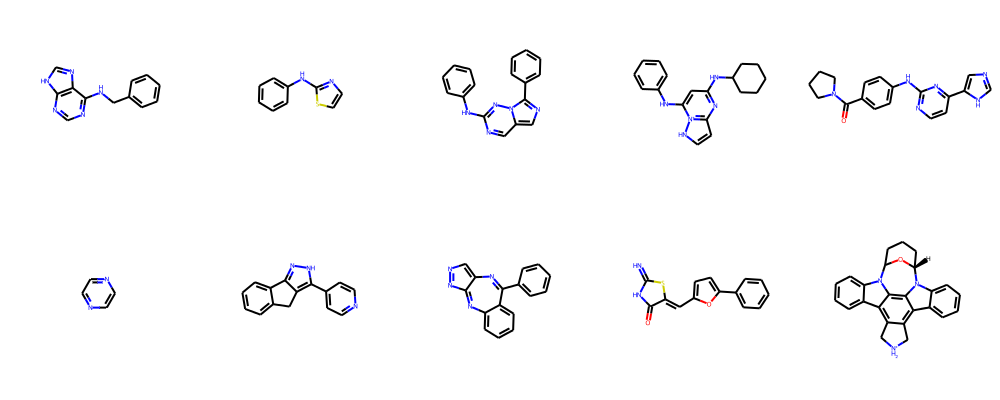

In [11]:
mols = [Chem.MolFromSmiles(smiles) for smiles in scaffolds]
Draw.MolsToGridImage(mols[:10], molsPerRow=5)

In [12]:
def get_model(split, iteration) :
    experiment_name = f'{split}_split_{iteration}'
    checkpoint_name = os.listdir(os.path.join('lightning_logs_v2', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs_v2', experiment_name, 'checkpoints', checkpoint_name)
    if 'molsize' in experiment_name :
        model = MolSizeModel.load_from_checkpoint(checkpoint_path=checkpoint_path)
    else :
        model = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    model.eval()
    return model

In [13]:
def get_test_smiles_and_pdbs(split, iteration) :
    smiles_df = pd.read_csv('data/smiles_df.csv')
    data_dir = 'data/'
    if split in ['random', 'scaffold'] :
        
        with open(os.path.join(data_dir, f'ligand_{split}_splits', f'test_smiles_{split}_split_{iteration}.txt'), 'r') as f :
            test_smiles = f.readlines()
            test_smiles = [smiles.strip() for smiles in test_smiles]
        
        test_pdbs = smiles_df[smiles_df['smiles'].isin(test_smiles)]['id'].values
        
    else :
        
        with open(os.path.join(data_dir, 'protein_similarity_splits', f'test_pdb_protein_similarity_split_{iteration}.txt'), 'r') as f :
            test_pdbs = f.readlines()
            test_pdbs = [pdb.strip() for pdb in test_pdbs]
        
        test_smiles = smiles_df[smiles_df['id'].isin(test_pdbs)]['smiles'].unique()
        
    return test_smiles, test_pdbs

In [14]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
class SimilaritySearch() :
    
    def __init__(self, smiles_list) :
        self.smiles_list = list(set(smiles_list))
        self.mols = [Chem.MolFromSmiles(smiles) for smiles in self.smiles_list]
        self.fps = [self.get_morgan_fingerprint(mol) for mol in self.mols]
        
    def get_morgan_fingerprint(self, mol) :
        return AllChem.GetMorganFingerprint(mol, 3, useChirality=True)
        
    def get_similarity(self, fp1, fp2) :
        return DataStructs.TanimotoSimilarity(fp1, fp2)
        
    def find_closest_in_set(self, smiles, n=1) :
        if smiles in self.smiles_list :
            print('smiles in set, returning next closests')
            other_smiles_index = [i for i, s in enumerate(self.smiles_list) if s != smiles]
            smiles_list = [s for i, s in enumerate(self.smiles_list) if i in other_smiles_index]
            mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
            fps = [self.get_morgan_fingerprint(mol) for mol in mols]
        else :
            smiles_list = self.smiles_list
            mols = self.mols
            fps = self.fps
            
        input_mol = Chem.MolFromSmiles(smiles)
        input_fp = self.get_morgan_fingerprint(input_mol)
        sims = [self.get_similarity(input_fp, fp2) for fp2 in fps]
        sims = np.array(sims)
        best_sim_indexes = np.argsort(-sims)[:n] # negate to get best
        closest_smiles = [smiles_list[i] for i in best_sim_indexes]
        closest_sims = sims[best_sim_indexes]
        return closest_smiles, closest_sims

In [15]:
def get_dataset(gene_symbol, split, iteration, overwrite=False) :
    
    data_dir = 'data/'
    dataset_path = f'data/{gene_symbol}_{split}_{iteration}.p'
    
    if not os.path.exists(dataset_path) or overwrite :
        
        pdbbind_table = PDBBindMetadataProcessor().get_master_dataframe(remove_peptide_ligands=False)
        chembl_table = ChEMBLConnector().get_target_table()
        merged_table = pdbbind_table.merge(chembl_table, left_on='Uniprot ID', right_on='accession')
        gene_table = merged_table[merged_table['gene_symbol_lowercase'] == gene_symbol]
        gene_pdbs = gene_table['PDB code'].unique()

        test_smiles, test_pdbs = get_test_smiles_and_pdbs(split, iteration)
        gene_pdbs = [pdb for pdb in gene_pdbs if pdb in test_pdbs]
        
        pdbbind_chunks = [filename for filename in os.listdir(os.path.join(data_dir, 'processed')) if filename.startswith('pdbbind')]
        pdbbind_n_chunks = len(pdbbind_chunks)
        chunked_datasets = []
        for chunk_number in tqdm(range(pdbbind_n_chunks)) :
            chunked_dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                                  pdb_ids_list=gene_pdbs)
            chunked_datasets.append(chunked_dataset)
        dataset = ConcatDataset(chunked_datasets)
        
        torch.save(dataset, dataset_path)
        
    else :
        
        dataset = torch.load(dataset_path)
        
    return dataset

In [16]:
def get_train_smiles_and_pdbs(split, iteration) :
    smiles_df = pd.read_csv('data/smiles_df.csv')
    data_dir = 'data/'
    if split in ['random', 'scaffold'] :
        
        with open(os.path.join(data_dir, f'ligand_{split}_splits', f'train_smiles_{split}_split_{iteration}.txt'), 'r') as f :
            train_smiles = f.readlines()
            train_smiles = [smiles.strip() for smiles in train_smiles]
        
        train_pdbs = smiles_df[smiles_df['smiles'].isin(train_smiles)]['id'].values
        
    else :
        
        with open(os.path.join(data_dir, 'protein_similarity_splits', f'train_pdb_protein_similarity_split_{iteration}.txt'), 'r') as f :
            train_pdbs = f.readlines()
            train_pdbs = [pdb.strip() for pdb in train_pdbs]
        
        train_smiles = smiles_df[smiles_df['id'].isin(train_pdbs)]['smiles'].unique()
        
    return train_smiles, train_pdbs

In [17]:
split = 'random'
iteration = 0
pdbbind_table = PDBBindMetadataProcessor().get_master_dataframe(remove_peptide_ligands=False)
chembl_table = ChEMBLConnector().get_target_table()
merged_table = pdbbind_table.merge(chembl_table, left_on='Uniprot ID', right_on='accession')

gene_table = merged_table[merged_table['gene_symbol_lowercase'] == gene_symbol]
gene_pdbs = gene_table['PDB code'].unique()
gene_smiles = smiles_df[(smiles_df['id'].isin(gene_pdbs)) 
                        & (smiles_df['included'])]['smiles'].unique()

test_smiles, test_pdbs = get_test_smiles_and_pdbs(split, iteration)
gene_test_pdbs = [pdb for pdb in test_pdbs if pdb in gene_pdbs]
gene_test_smiles = [smiles for smiles in test_smiles if smiles in gene_smiles]

In [19]:
ss = SimilaritySearch(smiles_list=gene_smiles)
gene_in_closest = []
for smiles in gene_smiles :
    mol = Chem.MolFromSmiles(smiles)
    #display(mol)
    closest_smiles, closest_sims = ss.find_closest_in_set(smiles)
    #print(closest_sims)
    #display(Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in closest_smiles]))
    closest_pdbs = smiles_df[(smiles_df['smiles'].isin(closest_smiles)) 
                         & (smiles_df['included'])]['id'].unique()
    closest_pdbbind = merged_table[merged_table['PDB code'].isin(closest_pdbs)]
    genes = closest_pdbbind['gene_symbol_lowercase'].values
    print(genes)
    gene_in_closest.append(gene_symbol in genes)

smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['cdk2' 'pdpk1']
smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['cdk2' 'cdk2' 'cdk1' 'cdk1']
smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['aurka' 'cdk2']
smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['cdk2' 'cdk2' 'cdk5']
smiles in set, returning next closests
['cdk2']
smiles in set, returning next closests
['cdk2' 'nek2' 'cdk1']
smiles in set, returning next closests
['cdk2' 'cdk2']
smiles in set, r

In [20]:
train_smiles, train_pdbs = get_train_smiles_and_pdbs('random', 0)
ss = SimilaritySearch(smiles_list=train_smiles)
for smiles in gene_test_smiles :
    mol = Chem.MolFromSmiles(smiles)
    #display(mol)
    closest_smiles, closest_sims = ss.find_closest_in_set(smiles, n=3)
    print(closest_sims)
    #display(Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in closest_smiles]))
    closest_pdbs = smiles_df[(smiles_df['smiles'].isin(closest_smiles)) 
                         & (smiles_df['included'])]['id'].unique()
    closest_pdbbind = merged_table[merged_table['PDB code'].isin(closest_pdbs)]
    print(closest_pdbbind['gene_symbol_lowercase'])

[0.66666667 0.34848485 0.328     ]
3899     cdk2
3990     cdk2
8932    fgfr1
Name: gene_symbol_lowercase, dtype: object
[0.4122807  0.4122807  0.37894737]
3892     cdk2
4022     cdk2
10067     btk
Name: gene_symbol_lowercase, dtype: object
[0.47619048 0.44047619 0.40384615]
3868    cdk2
3886    cdk2
4022    cdk2
Name: gene_symbol_lowercase, dtype: object
[0.71134021 0.53508772 0.53508772]
3864    cdk2
3983    cdk2
3996    cdk2
Name: gene_symbol_lowercase, dtype: object
[0.57       0.55882353 0.53      ]
3902    cdk2
3945    cdk2
3946    cdk2
3991    cdk2
Name: gene_symbol_lowercase, dtype: object
[0.62385321 0.51260504 0.51260504]
3956    cdk2
3957    cdk2
4003    cdk2
Name: gene_symbol_lowercase, dtype: object
[0.64912281 0.5826087  0.55555556]
3814    cdk2
3983    cdk2
3996    cdk2
Name: gene_symbol_lowercase, dtype: object
[0.68888889 0.65625    0.53773585]
3815    cdk2
3874    cdk2
3917    cdk2
Name: gene_symbol_lowercase, dtype: object
[0.79545455 0.79069767 0.60194175]
3834    cd

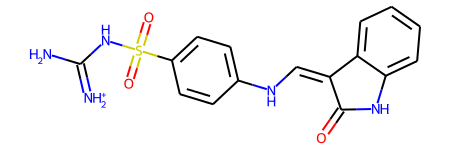

In [21]:
Chem.MolFromSmiles(gene_test_smiles[0])

In [22]:
train_smiles, train_pdbs = get_train_smiles_and_pdbs('random', 0)
ss = SimilaritySearch(smiles_list=train_smiles)

In [23]:
closest_smiles, closest_sims = ss.find_closest_in_set(gene_test_smiles[0], n=3)

In [24]:
closest_sims

array([0.66666667, 0.34848485, 0.328     ])

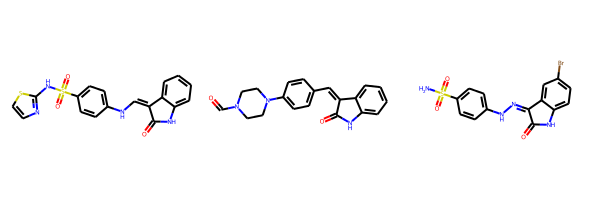

In [25]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in closest_smiles])

In [26]:
closest_pdbs = smiles_df[(smiles_df['smiles'].isin(closest_smiles)) 
                         & (smiles_df['included'])]['id'].unique()
closest_pdbbind = merged_table[merged_table['PDB code'].isin(closest_pdbs)]

In [27]:
closest_pdbbind

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active,accession,component_synonym,protein_class_desc,level2,gene_symbol_lowercase
3899,1ke8,2.00,2002,6.00,IC50=1uM //,1ke8.pdf,(LS4),"[uM, =, 1]",=,1000.0,nM,2002,P24941,CELL DIVISION PROTEIN KINASE 2,False,P24941,CDK2,enzyme kinase protein kinase cmgc cdk cdc2,enzyme kinase,cdk2
3990,1fvt,2.20,2001,7.22,IC50=60nM //,1fvt.pdf,(106),"[nM, =, 60]",=,60.0,nM,2001,P24941,CELL DIVISION PROTEIN KINASE 2,True,P24941,CDK2,enzyme kinase protein kinase cmgc cdk cdc2,enzyme kinase,cdk2
8932,1agw,2.40,1998,4.70,IC50=20uM //,1agw.pdf,(SU2),"[uM, =, 20]",=,20000.0,nM,1998,P11362,FGF RECEPTOR 1,False,P11362,FGFR1,enzyme kinase protein kinase tk fgfr,enzyme kinase,fgfr1


In [28]:
for split in ['random', 'scaffold'] :
    for iteration in range(5) :
        train_smiles, train_pdbs = get_train_smiles_and_pdbs(split, iteration)
        dataset = get_dataset(gene_symbol, split, iteration, True)

100%|█████████████████████████████████████████████| 3/3 [01:24<00:00, 28.18s/it]


In [29]:
for split in ['random', 'scaffold'] :
    for iteration in range(5) :
        train_smiles, train_pdbs = get_train_smiles_and_pdbs(split, iteration)
        dataset = get_dataset(gene_symbol, split, iteration)
        
        model = get_model(split, iteration)
        evaluation_name = f'cdk2_{split}_split_{iteration}_{split}_model'
        evaluator = RMSDPredictorEvaluator(model=model,
                                      evaluation_name=evaluation_name,
                                      training_smiles=train_smiles)
        evaluator.evaluate(dataset, overwrite=True)
        evaluator.evaluation_report()
        
        model = get_model('protein', 2)
        evaluation_name = f'cdk2_{split}_split_{iteration}_protein_model'
        evaluator = RMSDPredictorEvaluator(model=model,
                                      evaluation_name=evaluation_name,
                                      training_smiles=train_smiles)
        evaluator.evaluate(dataset, overwrite=True)
        evaluator.evaluation_report()

Computing training set fingerprints


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.97it/s]


Computing training set fingerprints


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 19.20it/s]


Computing training set fingerprints


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 24/24 [00:01<00:00, 19.98it/s]


Computing training set fingerprints


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 24/24 [00:01<00:00, 20.46it/s]


Computing training set fingerprints


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 24/24 [00:01<00:00, 19.26it/s]


Computing training set fingerprints


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 24/24 [00:01<00:00, 19.63it/s]


Computing training set fingerprints


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.79it/s]


Computing training set fingerprints
Grouping data by smiles


 10%|████▍                                       | 2/20 [00:00<00:01, 16.75it/s]

Starting evaluation


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.12it/s]


Computing training set fingerprints


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 26/26 [00:01<00:00, 20.02it/s]


Computing training set fingerprints


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 26/26 [00:01<00:00, 19.72it/s]


Computing training set fingerprints


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 17.56it/s]


Computing training set fingerprints


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 17.45it/s]


Computing training set fingerprints


 12%|█████▌                                      | 2/16 [00:00<00:00, 16.70it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 20.22it/s]


Computing training set fingerprints


 12%|█████▌                                      | 2/16 [00:00<00:00, 18.13it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 20.45it/s]


Computing training set fingerprints


  0%|                                                    | 0/16 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 16.92it/s]


Computing training set fingerprints


  0%|                                                    | 0/16 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.45it/s]


Computing training set fingerprints


  0%|                                                    | 0/14 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 16.36it/s]


Computing training set fingerprints


  0%|                                                    | 0/14 [00:00<?, ?it/s]

Grouping data by smiles
Starting evaluation


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 17.25it/s]


Computing training set fingerprints
Grouping data by smiles


  6%|██▊                                         | 2/32 [00:00<00:01, 15.59it/s]

Starting evaluation


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 17.69it/s]


Computing training set fingerprints
Grouping data by smiles


  6%|██▊                                         | 2/32 [00:00<00:01, 15.63it/s]

Starting evaluation


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 16.61it/s]


In [33]:
bioactive_accuracy_df = pd.DataFrame()
regression_df = pd.DataFrame()
ranking_df = pd.DataFrame()
results_dir = 'results/'
for split in ['random', 'scaffold'] :
    for iteration in range(5) :
        evaluation_names = [f'cdk2_{split}_split_{iteration}_{split}_model',
                            f'cdk2_{split}_split_{iteration}_protein_model']

        for evaluation_name in evaluation_names :

            working_dir = os.path.join(results_dir, evaluation_name)
            for task in ['all'] :
                task_dir = os.path.join(working_dir, task)
                dataset_results_path = os.path.join(task_dir, f'dataset_results.p')
                with open(dataset_results_path, 'rb') as f:
                    dataset_results = pickle.load(f)

                split_name = split.capitalize()
                model_name = evaluation_name.split('_')[4]

                for ranker in ['model', 'energy', 'random'] :
                    dataset_results['bioactive_accuracy'][ranker]['Split'] = split_name
                    dataset_results['bioactive_accuracy'][ranker]['task'] = task
                    dataset_results['bioactive_accuracy'][ranker]['ranker'] = ranker
                    dataset_results['bioactive_accuracy'][ranker]['Model'] = model_name
                    bioactive_accuracy_df = bioactive_accuracy_df.append(pd.Series(dataset_results['bioactive_accuracy'][ranker]), ignore_index=True)

                for average_type in dataset_results['regression'] :
                    dataset_results['regression'][average_type]['Split'] = split_name
                    dataset_results['regression'][average_type]['task'] = task
                    dataset_results['regression'][average_type]['average_type'] = average_type
                    dataset_results['regression'][average_type]['Model'] = model_name
                    regression_df = regression_df.append(pd.Series(dataset_results['regression'][average_type]), ignore_index=True)

                for ranker in dataset_results['ranking'] :
                    dataset_results['ranking'][ranker]['Split'] = split_name
                    dataset_results['ranking'][ranker]['task'] = task
                    dataset_results['ranking'][ranker]['ranker'] = ranker
                    dataset_results['ranking'][ranker]['Model'] = model_name
                    ranking_df = ranking_df.append(pd.Series(dataset_results['ranking'][ranker]), ignore_index=True)

In [31]:
bioactive_accuracy_df = pd.DataFrame()
regression_df = pd.DataFrame()
ranking_df = pd.DataFrame()
results_dir = 'results/'
for split in splits :
    for iteration in range(5) :
        evaluation_name = f'cdk2_{split}_split_{iteration}'

        working_dir = os.path.join(results_dir, evaluation_name)
        for task in ['all'] :
            task_dir = os.path.join(working_dir, task)
            dataset_results_path = os.path.join(task_dir, f'dataset_results.p')
            with open(dataset_results_path, 'rb') as f:
                dataset_results = pickle.load(f)

            if split == 'protein' :
                if iteration == 2 :
                    split_name = 'Protein (No CDK2)'
                else :
                    split_name = 'Protein (CDK2 included)'
            else :
                split_name = split.capitalize()
                
            for ranker in ['model', 'energy', 'random'] :
                dataset_results['bioactive_accuracy'][ranker]['Split'] = split_name
                dataset_results['bioactive_accuracy'][ranker]['task'] = task
                dataset_results['bioactive_accuracy'][ranker]['ranker'] = ranker
                bioactive_accuracy_df = bioactive_accuracy_df.append(pd.Series(dataset_results['bioactive_accuracy'][ranker]), ignore_index=True)

            for average_type in dataset_results['regression'] :
                dataset_results['regression'][average_type]['Split'] = split_name
                dataset_results['regression'][average_type]['task'] = task
                dataset_results['regression'][average_type]['average_type'] = average_type
                regression_df = regression_df.append(pd.Series(dataset_results['regression'][average_type]), ignore_index=True)

            for ranker in dataset_results['ranking'] :
                dataset_results['ranking'][ranker]['Split'] = split_name
                dataset_results['ranking'][ranker]['task'] = task
                dataset_results['ranking'][ranker]['ranker'] = ranker
                ranking_df = ranking_df.append(pd.Series(dataset_results['ranking'][ranker]), ignore_index=True)

In [34]:
bioactive_accuracy_df.groupby(['Split', 'ranker', 'Model']).mean()

mean_top1_accuracy  median_all_bioactive  \
Split    ranker Model                                                
Random   energy protein             0.071140                  48.7   
                random              0.071140                  48.7   
         model  protein             0.154548                  11.7   
                random              0.373498                   4.4   
         random protein             0.035178                  44.7   
                random              0.000000                  39.9   
Scaffold energy protein             0.180698                  30.7   
                scaffold            0.180698                  30.7   
         model  protein             0.088286                  13.3   
                scaffold            0.192055                   7.9   
         random protein             0.046286                  34.3   
                scaffold            0.045536                  28.7   

                          median_min_bioactive  median_normalized_bioactive  \
Split    ranker Model                                                         
Random   energy protein                   43.6                     0.547525   
                random                    43.6                     0.547525   
         model  protein                   11.1                     0.155644   
                random                     4.0                     0.073994   
         random protein                   44.1                     0.482574   
                random                    37.2                     0.492122   
Scaffold energy protein                   37.5                     0.537121   
                scaffold                  37.5                     0.537121   
         model  protein                   12.8                     0.186161   
                scaffold                   8.3                     0.132923   
         random protein                   36.2                     0.499780   
                scaffold                  28.9                     0.395825   

                          q1_all_bioactive  q1_min_bioactive  \
Split    ranker Model                                          
Random   energy protein              16.40             13.60   
                random               16.40             13.60   
         model  protein               3.35              2.85   
                random                0.10              0.00   
         random protein              18.60             16.45   
                random               13.05             10.50   
Scaffold energy protein               8.00              8.15   
                scaffold              8.00              8.15   
         model  protein               4.80              4.70   
                scaffold              1.75              1.95   
         random protein              12.20             11.95   
                scaffold             12.15             12.05   

                          q1_normalized_bioactive  q3_all_bioactive  \
Split    ranker Model                                                 
Random   energy protein                  0.294673             86.85   
                random                   0.294673             86.85   
         model  protein                  0.044875             29.45   
                random                   0.000000             13.90   
         random protein                  0.279636             67.05   
                random                   0.304175             62.80   
Scaffold energy protein                  0.199375             73.65   
                scaffold                 0.199375             73.65   
         model  protein                  0.096311             34.30   
                scaffold                 0.040092             21.80   
         random protein                  0.234080             64.50   
                scaffold                 0.199289             51.00   

                          q3_min_bioactive  q3

In [35]:
ranking_df.groupby(['Split', 'ranker', 'Model']).mean()[['median_normalized_bioactive_like_rank', 'fraction_top_bioactive_like']]

median_normalized_bioactive_like_rank  \
Split    ranker Model                                             
Random   ccdc   protein                                0.027293   
                random                                 0.027293   
         energy protein                                0.037333   
                random                                 0.037333   
         model  protein                                0.020128   
                random                                 0.005000   
         random protein                                0.055294   
                random                                 0.049696   
Scaffold ccdc   protein                                0.019667   
                scaffold                               0.019667   
         energy protein                                0.047333   
                scaffold                               0.047333   
         model  protein                                0.012000   
                scaffold                               0.013667   
         random protein                                0.025564   
                scaffold                               0.012136   

                          fraction_top_bioactive_like  
Split    ranker Model                                  
Random   ccdc   protein                      0.384286  
                random                       0.384286  
         energy protein                      0.374286  
                random                       0.374286  
         model  protein                      0.446905  
                random                       0.565000  
         random protein                      0.164167  
                random                       0.225714  
Scaffold ccdc   protein                      0.409713  
                scaffold                     0.409713  
         energy protein                      0.344886  
                scaffold                     0.344886  
         model  protein                      0.484121  
                scaffold                     0.446579  
         random protein                      0.336072  
                scaffold                     0.456905

In [36]:
regression_df = regression_df[regression_df['average_type'] == 'Micro']

In [37]:
regression_df['R²'] = regression_df['r2_all']
regression_df['RMSE'] = regression_df['rmse_all']

In [38]:
grouped_regression_df = regression_df[['Split', 'Model', 'R²', 'RMSE']].groupby(['Split', 'Model'], sort=False).mean()

In [39]:
grouped_regression_df

R²      RMSE
Split    Model                       
Random   random    0.392748  0.537887
         protein   0.329746  0.558038
Scaffold scaffold  0.351622  0.524985
         protein   0.313806  0.539208

In [40]:
bioactive_accuracy_df['Fraction of molecules with bioactive first'] = bioactive_accuracy_df['mean_top1_accuracy']
bioactive_accuracy_df['Median normalized rank of bioactive'] = bioactive_accuracy_df['median_normalized_bioactive']

In [41]:
bioactive_accuracy_df = bioactive_accuracy_df[bioactive_accuracy_df['ranker'] == 'model']
grouped_bioactive_df = bioactive_accuracy_df[['Split', 'Model', 'Fraction of molecules with bioactive first', 'Median normalized rank of bioactive']].groupby(['Split', 'Model'], sort=False).mean()

In [42]:
grouped_bioactive_df

Fraction of molecules with bioactive first  \
Split    Model                                                  
Random   random                                      0.373498   
         protein                                     0.154548   
Scaffold scaffold                                    0.192055   
         protein                                     0.088286   

                   Median normalized rank of bioactive  
Split    Model                                          
Random   random                               0.073994  
         protein                              0.155644  
Scaffold scaffold                             0.132923  
         protein                              0.186161

In [43]:
ranking_df['Median normalized rank of bioactive-like'] = ranking_df['median_normalized_bioactive_like_rank']
ranking_df['Fraction of molecules with bioactive-like first'] = ranking_df['fraction_top_bioactive_like']

In [44]:
ranking_df = ranking_df[ranking_df['ranker'] == 'model']
grouped_ranking_df = ranking_df[['Split', 'Fraction of molecules with bioactive-like first', 'Median normalized rank of bioactive-like', 'Model']].groupby(['Split', 'Model'], sort=False).mean()

In [45]:
grouped_ranking_df

Fraction of molecules with bioactive-like first  \
Split    Model                                                       
Random   random                                           0.565000   
         protein                                          0.446905   
Scaffold scaffold                                         0.446579   
         protein                                          0.484121   

                   Median normalized rank of bioactive-like  
Split    Model                                               
Random   random                                    0.005000  
         protein                                   0.020128  
Scaffold scaffold                                  0.013667  
         protein                                   0.012000

In [46]:
grouped_df = grouped_regression_df.join(grouped_bioactive_df).join(grouped_ranking_df)

In [47]:
grouped_df.round(3)

R²   RMSE  Fraction of molecules with bioactive first  \
Split    Model                                                                
Random   random    0.393  0.538                                       0.373   
         protein   0.330  0.558                                       0.155   
Scaffold scaffold  0.352  0.525                                       0.192   
         protein   0.314  0.539                                       0.088   

                   Median normalized rank of bioactive  \
Split    Model                                           
Random   random                                  0.074   
         protein                                 0.156   
Scaffold scaffold                                0.133   
         protein                                 0.186   

                   Fraction of molecules with bioactive-like first  \
Split    Model                                                       
Random   random                                              0.565   
         protein                                             0.447   
Scaffold scaffold                                            0.447   
         protein                                             0.484   

                   Median normalized rank of bioactive-like  
Split    Model                                               
Random   random                                       0.005  
         protein                                      0.020  
Scaffold scaffold                                     0.014  
         protein                                      0.012

In [48]:
regression_df

,Model,Split,average_type,pearson_all,pearson_gen,r2_all,r2_gen,rmse_all,rmse_bio,rmse_gen,spearman_all,spearman_gen,task,R²,RMSE
0,random,Random,Micro,0.634051,0.625541,0.174670,0.139644,0.505357,0.933559,0.492686,0.706205,0.701874,all,0.174670,0.505357
2,protein,Random,Micro,0.411106,0.416371,-0.074174,-0.105339,0.576530,1.327449,0.558443,0.479870,0.478266,all,-0.074174,0.576530
4,random,Random,Micro,0.746846,0.756005,0.398368,0.404507,0.602573,1.301176,0.583320,0.688698,0.689201,all,0.398368,0.602573
6,protein,Random,Micro,0.743164,0.757207,0.465856,0.473006,0.567771,1.273466,0.548746,0.706236,0.712475,all,0.465856,0.567771
8,random,Random,Micro,0.743969,0.742784,0.405377,0.373113,0.537518,0.862382,0.529251,0.728853,0.723615,all,0.405377,0.537518
10,protein,Random,Micro,0.709255,0.723709,0.438242,0.435559,0.522453,1.314186,0.502200,0.710382,0.713781,all,0.438242,0.522453
12,random,Random,Micro,0.706633,0.710070,0.463860,0.455422,0.531149,1.008893,0.517462,0.721103,0.721463,all,0.463860,0.531149
14,protein,Random,Micro,0.743676,0.751851,0.519017,0.517873,0.503086,1.082340,0.486888,0.728404,0.729946,all,0.519017,0.503086
16,random,Random,Micro,0.737251,0.741425,0.521467,0.516495,0.512836,1.047554,0.498212,0.725692,0.723939,all,0.521467,0.512836
18,protein,Random,Micro,0.654480,0.671511,0.299786,0.299087,0.620351,1.367965,0.599855,0.612061,0.619210,all,0.299786,0.620351


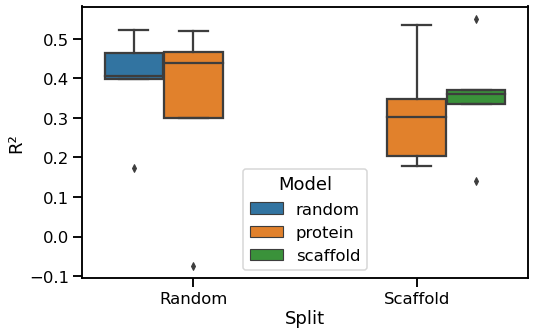

In [49]:
data = regression_df[regression_df['average_type'] == 'Micro']
with sns.plotting_context('talk') :
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, x='Split', y='R²', hue='Model')
    #plt.ylim(0)

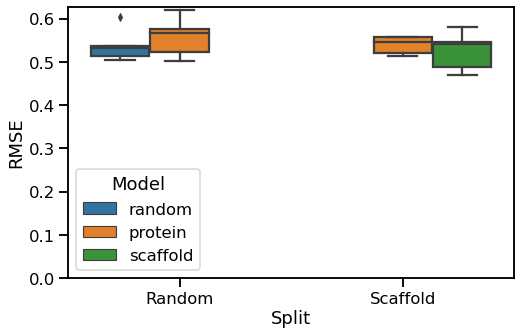

In [50]:
data = regression_df[regression_df['average_type'] == 'Micro']
with sns.plotting_context('talk') :
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, x='Split', y='RMSE', hue='Model')
    plt.ylim(0)

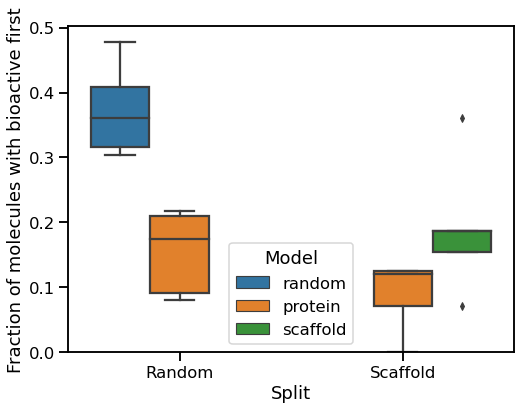

In [51]:
data = bioactive_accuracy_df[bioactive_accuracy_df['ranker'] == 'model']
with sns.plotting_context('talk') :
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, x='Split', y='Fraction of molecules with bioactive first', hue='Model')
    plt.ylim(0)

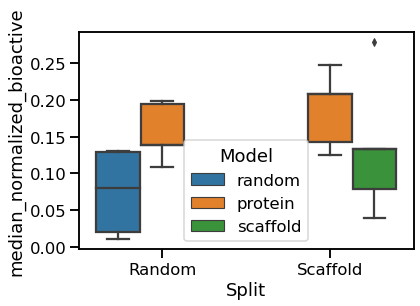

In [52]:
data = bioactive_accuracy_df[bioactive_accuracy_df['ranker'] == 'model']
with sns.plotting_context('talk') :
    sns.boxplot(data=data, x='Split', y='median_normalized_bioactive', hue='Model')

In [53]:
ranking_df[ranking_df['ranker'] == 'model'][['median_normalized_bioactive_like_rank', 'fraction_top_bioactive_like']]

,median_normalized_bioactive_like_rank,fraction_top_bioactive_like
3,0.000000,0.700000
7,0.015638,0.450000
11,0.005000,0.500000
15,0.025000,0.350000
19,0.020000,0.380952
23,0.050000,0.333333
27,0.000000,0.625000
31,0.000000,0.625000
35,0.000000,0.619048
39,0.010000,0.476190


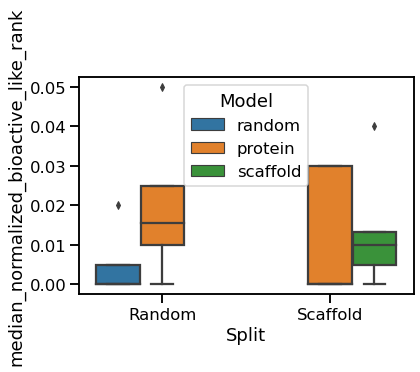

In [54]:
data = ranking_df[ranking_df['ranker'] == 'model']
with sns.plotting_context('talk') :
    sns.boxplot(data=data, x='Split', y='median_normalized_bioactive_like_rank', hue='Model')

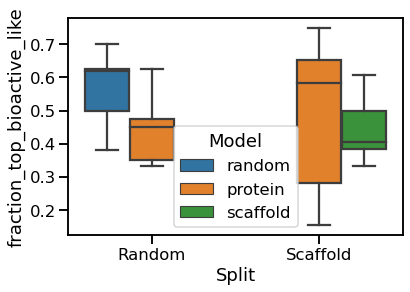

In [55]:
with sns.plotting_context('talk') :
    sns.boxplot(data=data, x='Split', y='fraction_top_bioactive_like', hue='Model')

In [56]:
with sns.plotting_context('talk') :
    data = ranking_df[ranking_df['ranker'] == 'random']
    sns.boxplot(data=data, x='Split', y='fraction_top_bioactive_like')

ValueError: min() arg is an empty sequence